In [2]:
import numpy as np
import matplotlib.pyplot as pl
import functools as ft
from tools.helpers import Progress

In [3]:
from pypllon.experiment import *

def systematic_error(invec, strength=0.0):
    """Scales all angles of the phaseshifters by a constant `strength"""
    alpha, phi = invec_to_phases(invec)
    alpha = (alpha - np.pi) / (1 + strength)
    phi = (phi - np.pi) / (1 + strength)
    return phases_to_invec(alpha + np.pi, phi + np.pi)

In [14]:
from pypllon import recover, lr_recover_l2, best_tmat_phases

def generate_setting(target, nr_measurements, invecgen, sigma_sys, sigma_rand):
    
    def sample(seed):
        rgen = np.random.RandomState(seed)
        errs = rgen.randn(nr_measurements, len(target))
        invecs = invecgen(len(target), nr_measurements, rgen=rgen,
                          normalized=True)
        
        # add artificial systematic errors to input vectors
        invecs_err = np.array([systematic_error(invec, strength=sigma_sys)
                              for invec in invecs])
        expvals = np.abs(np.tensordot(invecs_err, target, axes=(1, 1)))**2
        expvals += sigma_rand * errs
        
        recov = recover(invecs, expvals, optim_func=lr_recover_l2)
        recov, _ = best_tmat_phases(target, recov)
        return np.max(np.abs(target - recov))
    
    return sample

In [15]:
# helper functions to use (small) numpy arrays with lru_cache
def to_tuple(xs):
    try:
        return tuple(to_tuple(x) for x in iter(xs))
    except TypeError:
        return xs
    
def hashable_arrays(func):
    def result(*args, **kwargs):
        targs = tuple(to_tuple(arg) for arg in args)
        tkwargs = {key: to_tuple(val) for key, val in kwargs.items()}
        return func(*targs, **tkwargs)
    return result


## Depedence on nr. of Measurements

In [16]:
from pypllon import invecs_gaussian, invecs_recr

ENSEMBLES = {'GAUSS': invecs_gaussian, 'RECR': invecs_recr}

@hashable_arrays
@ft.lru_cache(maxsize=128)
def measurement_scan(target, measurements, sigma_sys, sigma_rand, seeds):
    result = {}
    for key, invecgen in ENSEMBLES.items():
        errs = [[generate_setting(target=target, 
                                  nr_measurements=m,
                                  invecgen=invecgen,
                                  sigma_sys=sigma_sys,
                                  sigma_rand=sigma_rand)(seed)
                 for seed in seeds] for m in Progress(measurements)]
        result[key] = np.sort(errs, axis=-1)
    return result

 87% (7 of 8) |###############################     | Elapsed Time: 0:03:43 ETA: 0:00:31

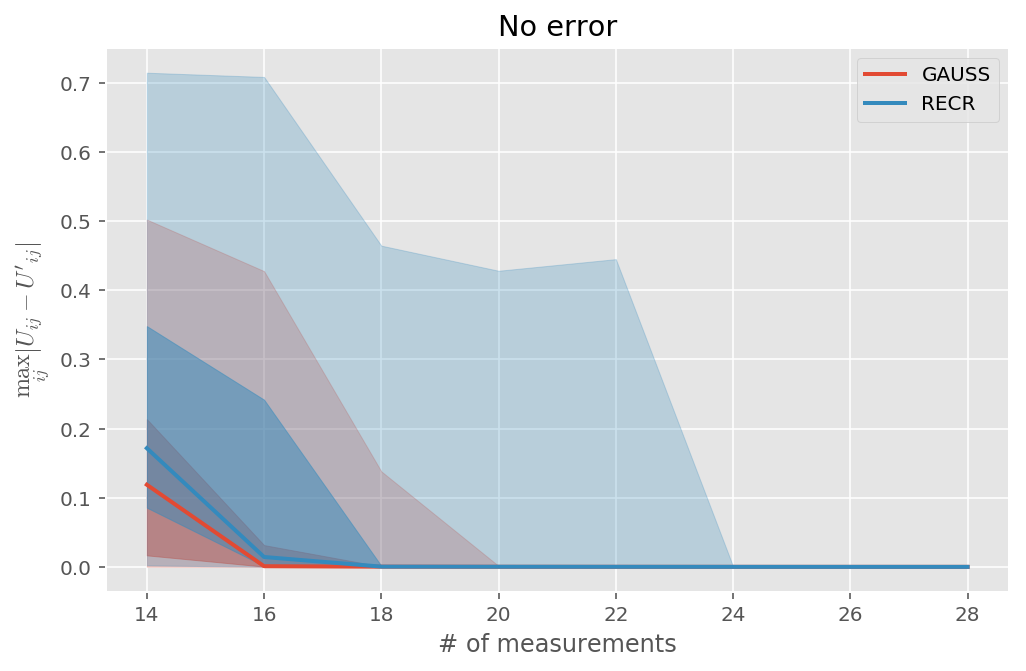

In [17]:
from scipy.linalg import dft

DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=123).randint(0, high=2**31, size=50)
MEASUREMENTS = np.arange(14, 30, 2)

result = measurement_scan(TARGET, MEASUREMENTS, 0.0, 0.0, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(MEASUREMENTS, np.median(errs, axis=-1), label=key)
    pl.fill_between(MEASUREMENTS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(MEASUREMENTS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title("No error")
pl.xlabel("# of measurements")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()

 92% (12 of 13) |###############################   | Elapsed Time: 0:07:25 ETA: 0:00:40

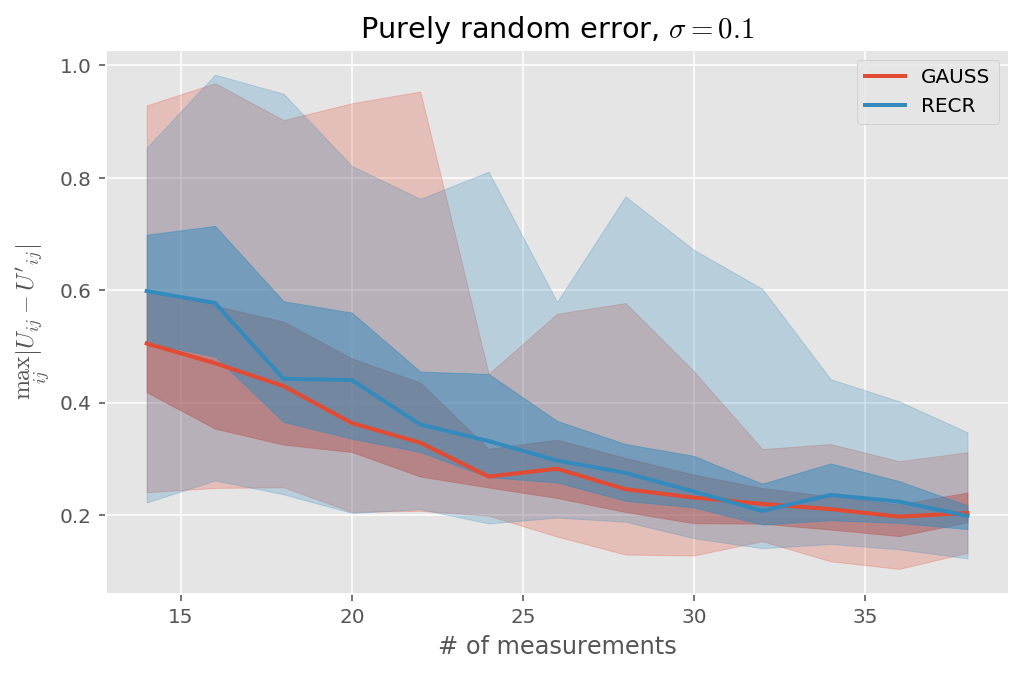

In [18]:
DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
MEASUREMENTS = np.arange(14, 40, 2)

result = measurement_scan(TARGET, MEASUREMENTS, 0.0, 0.1, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(MEASUREMENTS, np.median(errs, axis=-1), label=key)
    pl.fill_between(MEASUREMENTS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(MEASUREMENTS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely random error, $\sigma=0.1$")
pl.xlabel("# of measurements")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()

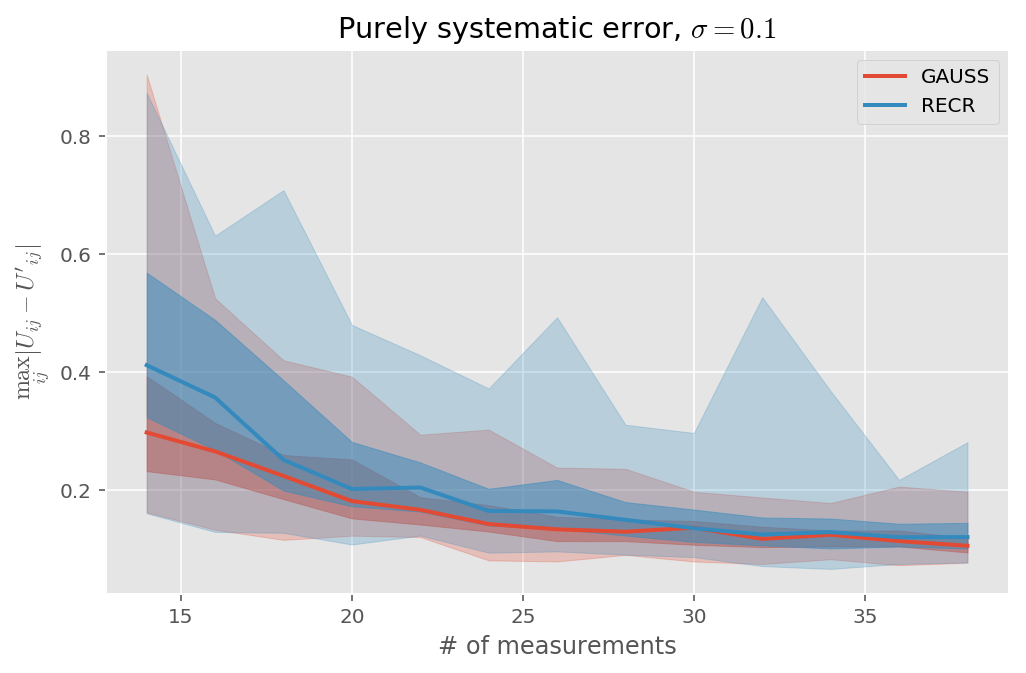

In [30]:
from scipy.linalg import dft 
from tools.helpers import Progress

DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
MEASUREMENTS = np.arange(14, 40, 2)

result = measurement_scan(TARGET, MEASUREMENTS, 0.1, 0.0, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(MEASUREMENTS, np.median(errs, axis=-1), label=key)
    pl.fill_between(MEASUREMENTS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(MEASUREMENTS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely systematic error, $\sigma=0.1$")
pl.xlabel("# of measurements")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()
pl.show()

## Depedence on Error strenght

In [25]:
@hashable_arrays
@ft.lru_cache(maxsize=128)
def sigma_rand_scan(target, measurements, sigma_sys, sigma_rand_s, seeds):
    result = {}
    for key, invecsgen in ENSEMBLES.items():
        errs = [[generate_setting(target=target, 
                                  nr_measurements=measurements,
                                  invecgen=invecsgen,
                                  sigma_sys=sigma_sys,
                                  sigma_rand=sigma)(seed)
                 for seed in seeds] for sigma in Progress(sigma_rand_s)]
        result[key] = np.sort(errs, axis=-1)
    return result

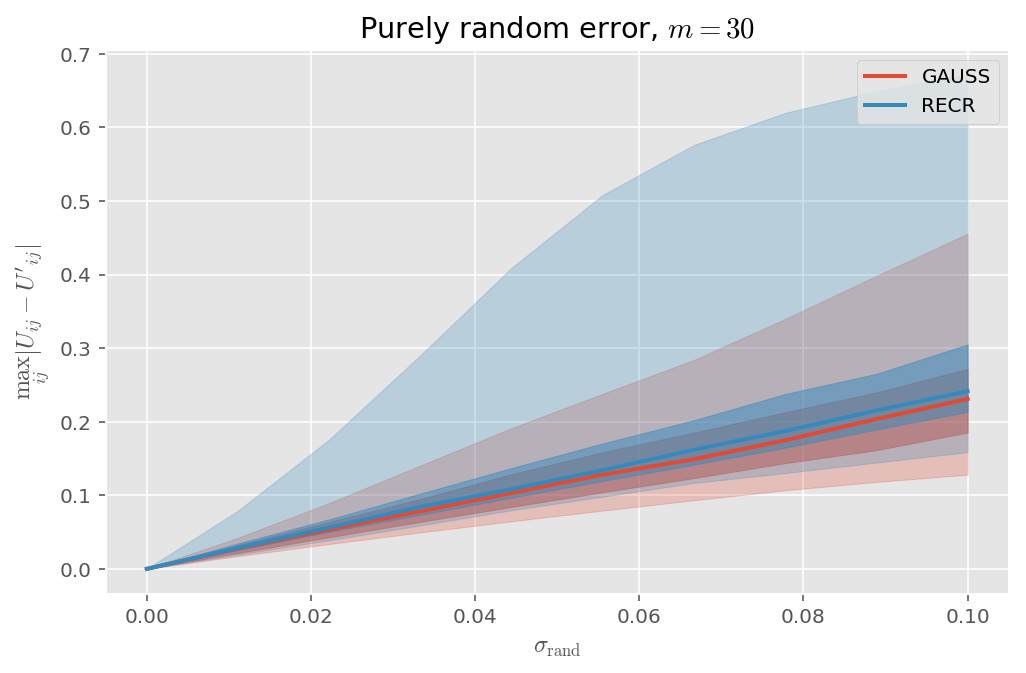

In [31]:
DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
SIGMAS = np.linspace(0, 0.1, 10)

result = sigma_rand_scan(TARGET, 30, 0.0, SIGMAS, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(SIGMAS, np.median(errs, axis=-1), label=key)
    pl.fill_between(SIGMAS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(SIGMAS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely random error, $m=30$")
pl.xlabel(r"$\sigma_\mathrm{rand}$")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()
pl.show()

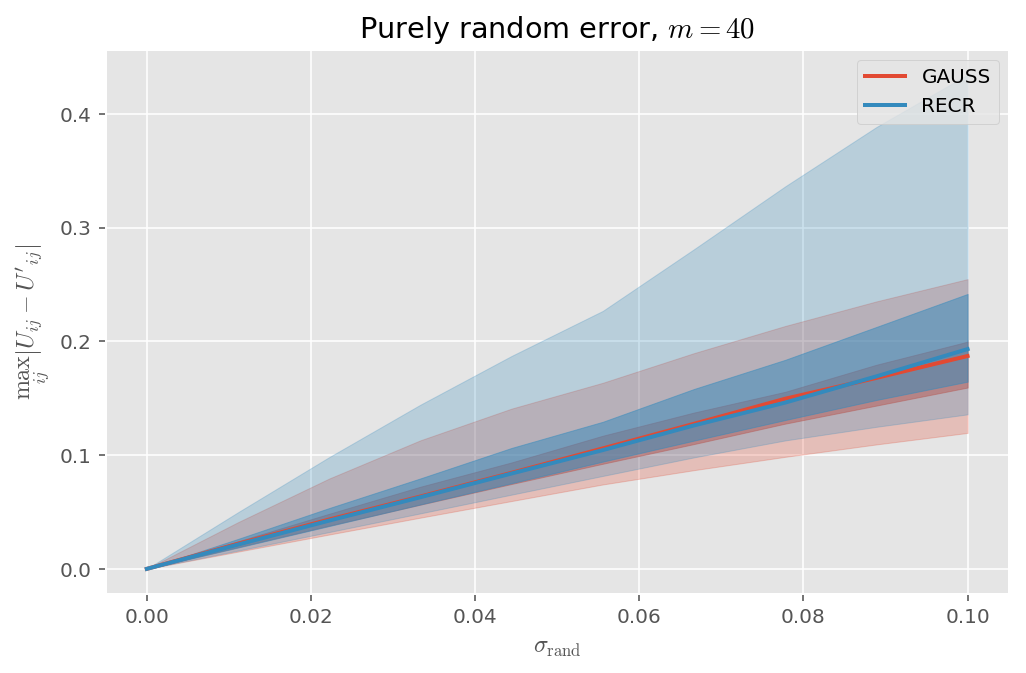

In [32]:
DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
SIGMAS = np.linspace(0, 0.1, 10)

result = sigma_rand_scan(TARGET, 40, 0.0, SIGMAS, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(SIGMAS, np.median(errs, axis=-1), label=key)
    pl.fill_between(SIGMAS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(SIGMAS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely random error, $m=40$")
pl.xlabel(r"$\sigma_\mathrm{rand}$")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()
pl.show()

In [37]:
@hashable_arrays
@ft.lru_cache(maxsize=128)
def sigma_sys_scan(target, measurements, sigma_sys_s, sigma_rand, seeds):
    result = {}
    for key, invecgen in ENSEMBLES.items():
        errs = [[generate_setting(target=TARGET, 
                                  nr_measurements=measurements,
                                  invecgen=invecgen,
                                  sigma_sys=sigma,
                                  sigma_rand=sigma_rand)(seed)
                 for seed in seeds] for sigma in Progress(sigma_sys_s)]
        result[key] = np.sort(errs, axis=-1)
    return result

 90% ( 9 of 10) |##############################    | Elapsed Time: 0:06:02 ETA: 0:00:40

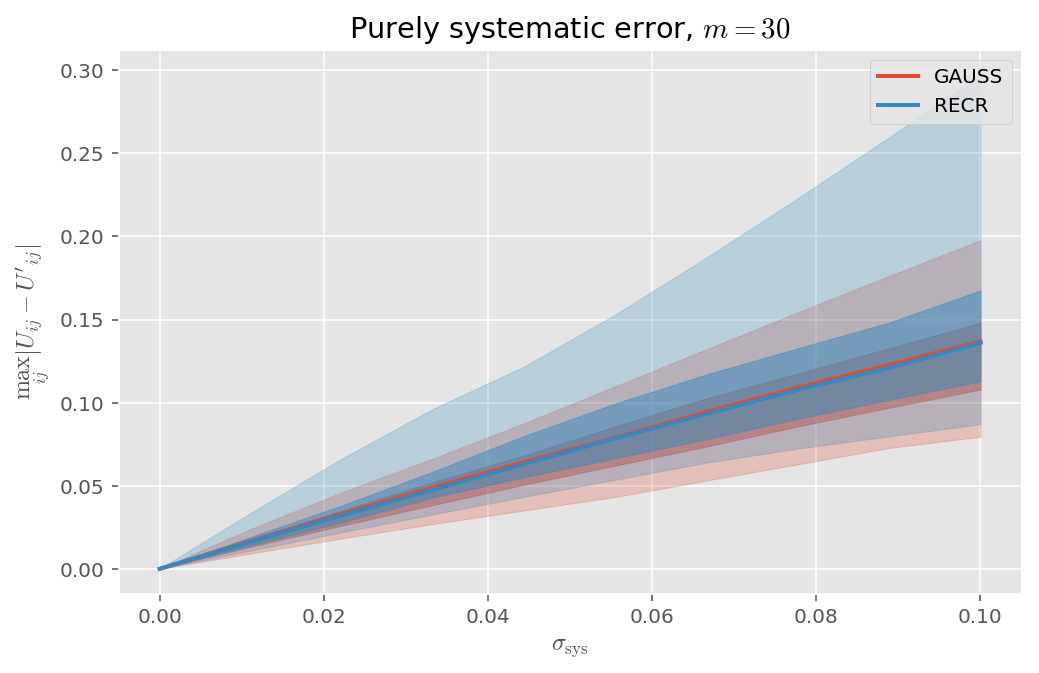

In [38]:
DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
SIGMAS = np.linspace(0, 0.1, 10)

result = sigma_sys_scan(TARGET, 30, SIGMAS, 0.0, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(SIGMAS, np.median(errs, axis=-1), label=key)
    pl.fill_between(SIGMAS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(SIGMAS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely systematic error, $m=30$")
pl.xlabel(r"$\sigma_\mathrm{sys}$")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()
pl.show()

 90% ( 9 of 10) |##############################    | Elapsed Time: 0:07:37 ETA: 0:00:50

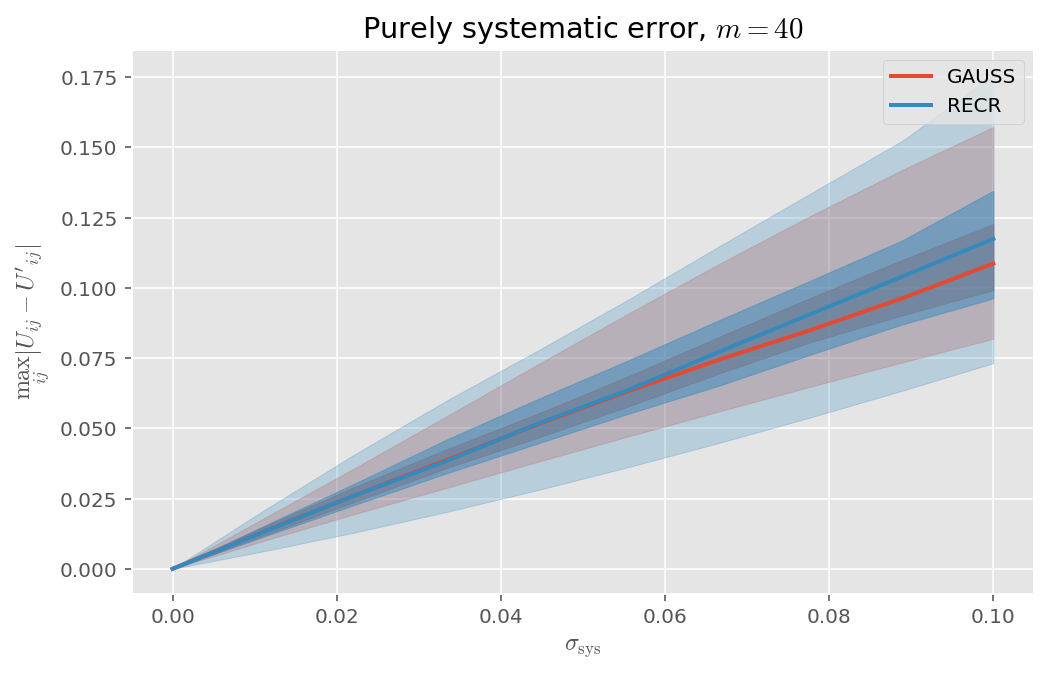

In [40]:
DIM = 5
TARGET = dft(DIM, scale='sqrtn')
SEEDS = np.random.RandomState(seed=1234).randint(0, high=2**31, size=50)
SIGMAS = np.linspace(0, 0.1, 10)

result = sigma_sys_scan(TARGET, 40, SIGMAS, 0.0, SEEDS)

for key, errs in result.items():
    n = errs.shape[1]
    l, *_ = pl.plot(KAPPAS, np.median(errs, axis=-1), label=key)
    pl.fill_between(KAPPAS, errs[:, n // 4], errs[:, 3 * n // 4],
                    color=l.get_c(), alpha=.5)
    pl.fill_between(KAPPAS, errs[:, 0], errs[:, -1],
                    color=l.get_c(), alpha=.25)
  
pl.title(r"Purely systematic error, $m=40$")
pl.xlabel(r"$\sigma_\mathrm{sys}$")
pl.ylabel(r"$\max_{ij} \left\vert U_{ij} - U'_{ij} \right\vert$")
pl.legend()
pl.show()

In [41]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_text').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')